# Molecule standardization
When building machine learning models of molecules, it is important to standardize the molecules. We often don't want different predictions just because things are drawn in slightly different forms, such as protonated or deprotanted carboxylic acids. Scikit-mol provides a very basic standardize transformer based on the molvs implementation in RDKit

In [1]:
from rdkit import Chem
from scikit_mol.standardizer import Standardizer
from scikit_mol.fingerprints import MorganFingerprintTransformer
from scikit_mol.conversions import SmilesToMolTransformer
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import Ridge

For demonstration let's create some molecules with different protonation states. The two first molecules are Benzoic acid and Sodium benzoate.

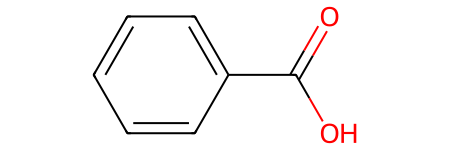

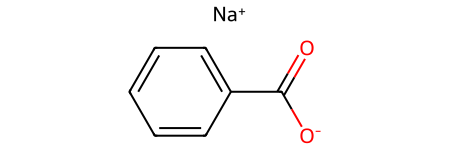

In [2]:
smiles_strings = ('c1ccccc1C(=O)[OH]','c1ccccc1C(=O)[O-].[Na+]','CC[NH+](C)C','CC[N+](C)(C)C',
       '[O-]CC(C(=O)[O-])C[NH+](C)C','[O-]CC(C(=O)[O-])C[N+](C)(C)C')

smi2mol = SmilesToMolTransformer()

mols  = smi2mol.transform(smiles_strings)
for mol in mols[0:2]:
    display(mol)

We can simply use the transformer directly and get a list of standardized molecules

In [3]:
# You can just run straight up like this. Note that neutralising is optional
standardizer = Standardizer(neutralize=True)
standard_mols = standardizer.transform(mols)
standard_smiles = smi2mol.inverse_transform(standard_mols)
standard_smiles

['O=C(O)c1ccccc1',
 'O=C(O)c1ccccc1',
 'CCN(C)C',
 'CC[N+](C)(C)C',
 'CN(C)CC(CO)C(=O)O',
 'C[N+](C)(C)CC(CO)C(=O)[O-]']

Some of the molecules were desalted and neutralized.

A typical usecase would be to add the standardizer to a pipeline for prediction

In [4]:
# Typical use case is to use it in an sklearn pipeline, like below 
predictor = Ridge()

std_pipe = make_pipeline(SmilesToMolTransformer(), Standardizer(), MorganFingerprintTransformer(useCounts=True), predictor)
nonstd_pipe = make_pipeline(SmilesToMolTransformer(), MorganFingerprintTransformer(useCounts=True), predictor)

fake_y = range(len(smiles_strings))

std_pipe.fit(smiles_strings, fake_y)


print(f'Predictions with no standardization: {std_pipe.predict(smiles_strings)}')
print(f'Predictions with standardization:    {nonstd_pipe.predict(smiles_strings)}')

Predictions with no standardization: [0.51983795 0.51983795 2.06562022 3.01206795 3.95446692 4.92816899]
Predictions with standardization:    [0.51983795 0.61543701 2.31738354 3.01206795 3.44085399 4.37516731]


As we can see, the predictions with the standardizer and without are different. The two first molecules were benzoic acid and sodium benzoate, which with the standardized pipeline is predicted as the same, but differently with the nonstandardized pipeline. Wheter we want to make the prediction on the parent compound, or predict the exact form, will of course depend on the use-case, but now there is at least a way to handle it easily in pipelined predictors.

The example also demonstrate another feature. We created the ridge regressor before creating the two pipelines. Fitting one of the pipelines thus also updated the object in the other pipeline. This can be useful for building inference pipelines that takes in SMILES molecules, but rather do the fitting on already converted and standardized molecules. However, be aware that the crossvalidation classes of scikit-learn may clone the estimators internally when doing the search loop, which would break this interdependence, and necessitate the rebuilding of the inference pipeline.

If we had fitted the non standardizing pipeline, the model would have been different as shown below, as some of the molecules would be perceived different by the Ridge regressor.

In [5]:
nonstd_pipe.fit(smiles_strings, fake_y)
print(f'Predictions with no standardization: {std_pipe.predict(smiles_strings)}')
print(f'Predictions with standardization:    {nonstd_pipe.predict(smiles_strings)}')

Predictions with no standardization: [0.07445775 0.07445775 2.32132164 3.00857908 2.68502208 4.30275549]
Predictions with standardization:    [0.07445775 0.96053374 2.05993278 3.00857908 3.96365443 4.93284221]
